In [1]:
INPUT_DIRECTORY = "../dataset"

In [2]:
import os
import base64
import requests
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report


Using TensorFlow backend.


In [177]:
from numpy import loadtxt
from keras.models import load_model


# En# Function Definition

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_



# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)




def load_data():
    filename = "standard_dataset_2000.csv"
    file = os.path.join(INPUT_DIRECTORY,filename)
    df1 = pd.read_csv(file)
    return df1

def preprocessall(df):
    print("Total number of features : ",len(df.columns))
    print("\n----Dropping features---")
    drop_columns = ['Timestamp','Src IP','Dst IP','Flow ID','Src Port']
    df.drop(drop_columns,inplace=True,axis=1)
    
    print("Number of features : ",len(df.columns))
    print("\n----Encoding categorical data---")
    
#     encode_text_dummy(df, 'Src Port')
#     encode_text_dummy(df, 'Dst Port')
    
    df.loc[df['SubLabel']=='Normal', 'SubLabel'] = 0
    df.loc[df['SubLabel']=='Port Scan', 'SubLabel'] = 1
    
    df.loc[df['SubLabel']=='DOS goldeneye', 'SubLabel'] = 6
    df.loc[df['SubLabel']=='DOS slowloris', 'SubLabel'] = 2

    df.loc[df['SubLabel']=='SSH Bruteforce', 'SubLabel'] = 3
    df.loc[df['SubLabel']=='FTP Bruteforce', 'SubLabel'] = 6
    
    df.loc[df['SubLabel']=='Malware Infiltration', 'SubLabel'] = 4
    
    print("Number of features after encoding : ",len(df.columns))
    
   
def oversample(dfx):
    max_size = dfx ['SubLabel'].value_counts().max()
    lst = [dfx ]
    for class_index, group in dfx .groupby('SubLabel'):
        lst.append(group.sample(max_size-len(group), replace=True))
    dfx_new = pd.concat(lst)
    return dfx_new
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def evaluate_multiclass(y_pred, y_eval):
    #evaluation
    from sklearn import metrics
    print(metrics.classification_report(y_eval,y_pred, target_names=['Normal', 'Scan','DOS','SSH Bruteforce','Malware']))
    print(f"Accuracy:{accuracy_score(y_eval,y_pred)*100}%")
    
    # Plot normalized confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    class_names = ['Normal', 'Scan','DOS','SSH Bruteforce','Malware']
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm, classes=class_names, normalize=False,title='Confusion matrix')
    plt.show()


    
def evaluate(y_pred, y_eval):
    #evaluation
    from sklearn import metrics
    print(metrics.classification_report(y_eval,y_pred, target_names=['Normal', 'Scan','DOS','SSH Bruteforce','Malware','Flood']))
    print(f"Accuracy:{accuracy_score(y_eval,y_pred)*100}%")
    
    # Plot normalized confusion matrix
    cm = confusion_matrix(y_eval, y_pred)
    class_names = ['Normal', 'Scan','DOS','SSH Bruteforce','Malware','Flood']
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm, classes=class_names, normalize=False,title='Confusion matrix')
    plt.show()
    

In [178]:
model1=load_model('../models/standard/model_79.hdf5')

In [179]:
# Loading Data

df = load_data()

#Sample view of dataset
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,172.16.0.1-192.168.10.50-54304-80-6,172.16.0.1,54304,192.168.10.50,80,6,5/7/17 9:56,100998466,2,2,...,75.0,0.0,75,75,101000000.0,0.0,101000000,101000000,Attack,DOS slowloris
1,174.129.244.5-192.168.10.14-443-50278-6,192.168.10.14,50278,174.129.244.5,443,6,3/7/17 9:15,5289004,9,6,...,237376.0,0.0,237376,237376,5051624.0,0.0,5051624,5051624,Normal,Normal
2,172.16.0.1-192.168.10.50-59608-80-6,172.16.0.1,59608,192.168.10.50,80,6,5/7/17 10:03,3001544,3,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Attack,DOS slowloris
3,172.16.0.1-192.168.10.50-55756-21-6,172.16.0.1,55756,192.168.10.50,21,6,4/7/17 9:46,9299172,9,15,...,0.0,0.0,0,0,0.0,0.0,0,0,Attack,FTP Bruteforce
4,172.16.0.1-192.168.10.50-41836-80-6,172.16.0.1,41836,192.168.10.50,80,6,5/7/17 11:18,107443065,2,1,...,0.0,0.0,0,0,107000000.0,0.0,107000000,107000000,Attack,DOS goldeneye


In [180]:
# Statistical Summary

df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,12036.000000,12036.000000,12036.000000,1.203600e+04,12036.000000,12036.000000,1.203600e+04,1.203600e+04,12036.000000,12036.000000,...,12036.000000,1.203600e+04,1.203600e+04,1.203600e+04,1.203600e+04,1.203600e+04,1.203600e+04,1.203600e+04,1.203600e+04,1.203600e+04
mean,46661.228232,2463.573612,6.478730,1.999021e+07,40.733882,50.867896,1.895164e+03,9.549100e+04,182.405367,3.681206,...,36.483965,-4.875585e+04,2.993656e+05,3.108096e+05,5.391593e+05,8.097931e+04,9.781776e+06,1.149531e+06,1.156076e+07,8.943452e+06
std,14388.352796,9146.728223,2.251926,3.480903e+07,2390.658179,3174.909985,4.754448e+04,7.105902e+06,434.850771,16.855415,...,2317.688137,2.022487e+06,1.190635e+06,1.276167e+06,2.017897e+06,7.519680e+05,2.447766e+07,4.936886e+06,2.628799e+07,2.430568e+07
min,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,-8.388531e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,41763.000000,22.000000,6.000000,7.400000e+01,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,50186.500000,80.000000,6.000000,5.007153e+06,2.000000,1.000000,1.800000e+01,6.000000e+00,14.000000,0.000000,...,1.000000,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,55517.500000,212.000000,6.000000,1.226173e+07,9.000000,6.000000,4.460000e+02,2.745000e+03,311.000000,0.000000,...,6.000000,3.200000e+01,3.400000e+01,0.000000e+00,3.400000e+01,2.825000e+01,6.147776e+06,0.000000e+00,6.148496e+06,5.739837e+06
max,65473.000000,65389.000000,17.000000,1.199999e+08,219759.000000,291922.000000,2.866110e+06,6.554530e+08,23360.000000,239.000000,...,213557.000000,4.400000e+01,3.430000e+07,2.610000e+07,4.240000e+07,2.620000e+07,1.190000e+08,6.650000e+07,1.190000e+08,1.190000e+08


In [181]:
# Label Distribution of Dataset

print('Label distribution of data set:')
print(df['SubLabel'].value_counts())

Label distribution of data set:
Port Scan               2000
Normal                  2000
DOS goldeneye           2000
SSH Bruteforce          2000
DOS slowloris           2000
FTP Bruteforce          2000
Malware Infiltration      36
Name: SubLabel, dtype: int64


In [182]:
# Step 1: Preprocessing and Encoding data

print("Shape of data:",df.shape)
preprocessall(df)

#changing data type
df['Flow Byts/s'] = df['Flow Byts/s'].astype('float32')
df['Flow Pkts/s'] = df['Flow Pkts/s'].astype('float32')
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)
df.drop(['Label'], inplace = True , axis=1)

df.head()

Shape of data: (12036, 85)
Total number of features :  85

----Dropping features---
Number of features :  80

----Encoding categorical data---
Number of features after encoding :  80


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SubLabel
0,80,6,17482509,8,6,390,11632,390,0,48.750000,...,32,845.0,0.0,845,845,12500000.0,0.0,12500000,12500000,6
1,80,6,99999288,2,2,16,0,8,8,8.000000,...,32,45.0,0.0,45,45,100000000.0,0.0,100000000,100000000,2
2,80,6,3001642,3,0,0,0,0,0,0.000000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,2
3,443,6,210858,10,8,561,4163,204,0,56.100000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,22,6,13055040,21,32,2008,2745,640,0,95.619048,...,32,0.0,0.0,0,0,0.0,0.0,0,0,3


In [183]:
df = df.drop(df[(df.SubLabel!= 0) & (df.SubLabel!= 1 )& (df.SubLabel!= 2)&(df.SubLabel!= 3)&(df.SubLabel!= 4)].index)

print(df['SubLabel'].value_counts())

encode_text_dummy(df,"SubLabel")



3    2000
2    2000
1    1999
0    1990
4      36
Name: SubLabel, dtype: int64


In [184]:

x = df.iloc[:,0:78].values  
y = df.iloc[:,78:83].values

In [185]:
# Feature Scaling
sc = StandardScaler()  
x = sc.fit_transform(x)  

                precision    recall  f1-score   support

        Normal       0.66      0.89      0.76      1990
          Scan       0.93      0.85      0.88      1999
           DOS       0.98      0.47      0.64      2000
SSH Bruteforce       0.90      0.99      0.95      2000
       Malware       0.01      0.11      0.02        36

      accuracy                           0.80      8025
     macro avg       0.70      0.66      0.65      8025
  weighted avg       0.86      0.80      0.80      8025

Accuracy:79.82554517133956%
Confusion matrix, without normalization


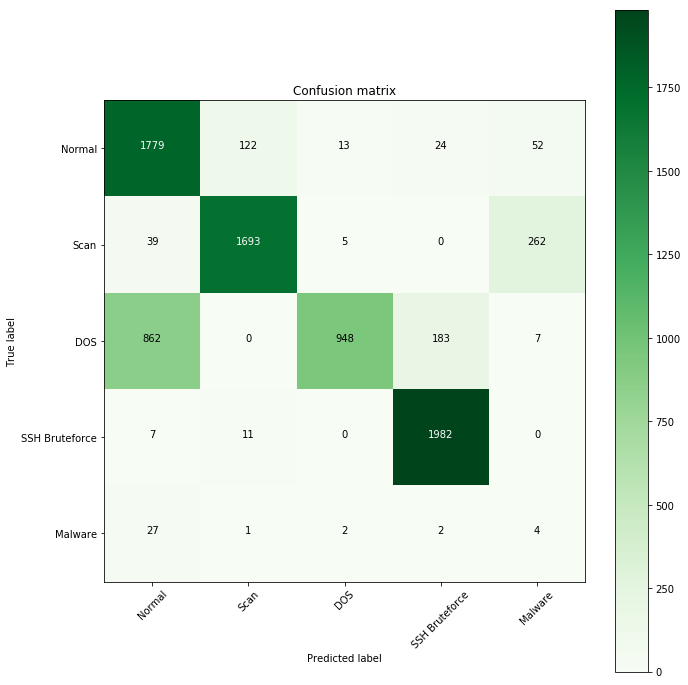

In [186]:
#DNN
#predict label
y_pred = model1.predict(x)
y_pred = np.argmax(y_pred,axis=1)
y_eval = np.argmax(y,axis=1)

evaluate_multiclass(y_pred, y_eval)